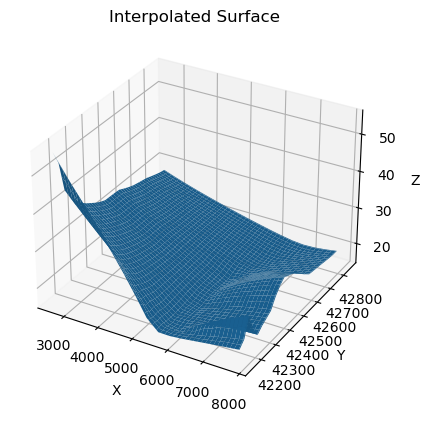

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Generate some sample data
data = np.genfromtxt('D:\Cours\MBA\Mémoire\code\QuantLibPythonOptionPricing\ImpliedVol.txt')
#expiry dates
y = data[:,0]
#strikes
x = data[:,1]
#implied volatilities
z = data[:,2]

# Define the grid onto which you want to interpolate the data
xi = np.linspace(x.min(), x.max(), len(x))  # x-coordinates of the grid
yi = np.linspace(y.min(), y.max(), len(y))  # y-coordinates of the grid
xi, yi = np.meshgrid(xi, yi)  # create the grid

# Interpolate the data onto the grid
zi = griddata((x, y), z, (xi, yi), method='linear')

# Plot the interpolated surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Interpolated Surface')
plt.show()


In [14]:
import numpy as np
from math import sqrt, pi,log, e
from scipy.stats import norm
import time
import copy

class Option(object):
    def __init__(self, args):
        self.Type = int(args[0])                # 1 for a Call, - 1 for a put
        self.S = float(args[1])                 # Underlying asset price
        self.K = float(args[2])                 # Option strike K
        self.r = float(args[3])                 # Continuous risk fee rate
        self.q = float(args[4])                 # Dividend continuous rate
        self.T = float(args[5]) / 365.0         # Compute time to expiry
        self._sigma = float(args[6])             # Underlying volatility
        self.sigmaT = self._sigma * self.T ** 0.5# sigma*T for reusability

    @property
    def d2(self):
        return self.d1 - self.sigmaT

class BSVanilla(Option):
    def __init__(self, args):
        super(BSVanilla, self).__init__(args)

    @property
    def d1(self):
        return (log(self.S / self.K) + (self.r - self.q + 0.5 * (self.sigma ** 2)) * self.T) / self.sigmaT

    @property
    def sigma(self):
        return self._sigma
    @sigma.setter
    def sigma(self, val):
        self._sigma = val
        self.sigmaT = val * self.T ** 0.5

    def Premium(self):
        tmpprem = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1) - \
				self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * self.d2))
        return tmpprem

    def Delta(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return dfq * norm.cdf(self.d1)
        else:
            return dfq * (norm.cdf(self.d1) - 1)

    def Vega(self):
        return 0.01 * self.S * e ** (-self.q * self.T) * \
          norm.pdf(self.d1) * self.T ** 0.5

    def Theta(self):
        df = e ** -(self.r * self.T)
        dfq = e ** (-self.q * self.T)
        tmptheta = (1.0 / 365.0) \
            * (-0.5 * self.S * dfq * norm.pdf(self.d1) * \
               self.sigma / (self.T ** 0.5) + \
	        self.Type * (self.q * self.S * dfq * norm.cdf(self.Type * self.d1) \
            - self.r * self.K * df * norm.cdf(self.Type * self.d2)))
        return tmptheta

    def Rho(self):
        df = e ** -(self.r * self.T)
        return self.Type * self.K * self.T * df * 0.01 * norm.cdf(self.Type * self.d2)

    def Phi(self):
	    return 0.01 * -self.Type * self.T * self.S * \
             e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1)
    
    def Gamma(self):
	    return e ** (-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigmaT)

    def Charm(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                            + (-self.q) * norm.cdf(self.d1))
        else:
            return (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                            + self.q * norm.cdf(-self.d1))

    # Vanna for 1% change in vol
    def Vanna(self):
        return 0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)

    # Vomma
    def Vomma(self):
        return 0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)

# Geometric Continuous Average-Rate Options
# Following Kemna and Vorst (1990), see Haug
class BSAsian(Option):
    def __init__(self, args):
        super(BSAsian, self).__init__(args)
        self.sigmaT = self.sigmaa * self.T ** 0.5

    @property
    def d1(self):
        return (log(self.S / self.K) + (self.ba + 0.5 * (self.sigmaa ** 2)) * self.T) / self.sigmaT

    @property
    def sigmaa(self):
        return self._sigma / (3.0 ** 0.5)

    @property
    def sigma(self):
        return self._sigma
    @sigma.setter
    def sigma(self, val):
        self._sigma = val
        self.sigmaT = self.sigmaa * self.T ** 0.5

    @property
    def ba(self):
        return 0.5 * (self.r - self.q - (self._sigma ** 2) / 6.0)

    def Premium(self):
        tmpprem = self.Type * (self.S * e ** ((self.ba - self.r) * self.T) * norm.cdf(self.Type * self.d1) - \
				self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * self.d2))
        return tmpprem

C:\Users\barna\AppData\Local\Temp\ipykernel_25020\3462068952.py:34: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


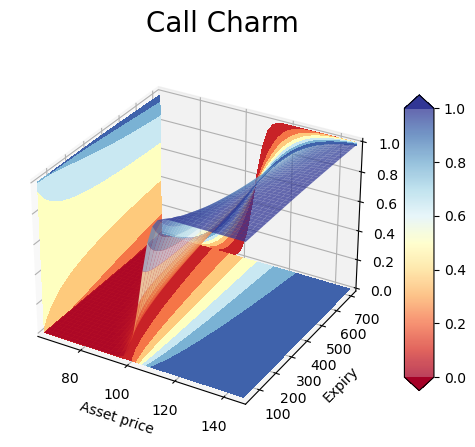

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
# import OptionsAnalytics
# from OptionsAnalytics import BSAsian

# Option parameters
sigma = 0.12        # Flat volatility
strike = 105.0      # Fixed strike
epsilon = 0.4       # The % on the left/right of Strike. 
                    # Asset prices are centered around Spot ("ATM Spot")
shortexpiry = 30    # Shortest expiry in days
longexpiry = 720    # Longest expiry in days
riskfree = 0.00     # Continuous risk free rate
divrate = 0.00      # Continuous div rate

# Grid definition
dx, dy = 40, 40     # Steps throughout asset price and expiries axis

# xx: Asset price axis, yy: expiry axis, zz: greek axis
xx, yy = np.meshgrid(np.linspace(strike*(1-epsilon), (1+epsilon)*strike, dx), \
    np.linspace(shortexpiry, longexpiry, dy))
# print "Calculating greeks ..."
zz = np.array([BSVanilla([1,x,strike,riskfree,divrate,y,sigma]).Delta() for
               x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

# Plot greek surface
# print "Plotting surface ..."
fig = plt.figure()
fig.suptitle('Call Charm',fontsize=20)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, zz,rstride=1, cstride=1,alpha=0.75,cmap=cm.RdYlBu)
ax.set_xlabel('Asset price')
ax.set_ylabel('Expiry')
ax.set_zlabel('Charm')

# Plot 3D contour
zzlevels = np.linspace(zz.min(),zz.max(),num=8,endpoint=True)
xxlevels = np.linspace(xx.min(),xx.max(),num=8,endpoint=True)
yylevels = np.linspace(yy.min(),yy.max(),num=8,endpoint=True)
cset = ax.contourf(xx, yy, zz, zzlevels, zdir='z',offset=zz.min(),
                   cmap=cm.RdYlBu,linestyles='dashed')
cset = ax.contourf(xx, yy, zz, xxlevels, zdir='x',offset=xx.min(),
                   cmap=cm.RdYlBu,linestyles='dashed')
cset = ax.contourf(xx, yy, zz, yylevels, zdir='y',offset=yy.max(),
                   cmap=cm.RdYlBu,linestyles='dashed')

for c in cset.collections:
    c.set_dashes([(0, (2.0, 2.0))]) # Dash contours

plt.clabel(cset,fontsize=10, inline=1)

ax.set_xlim(xx.min(),xx.max())
ax.set_ylim(yy.min(),yy.max())
ax.set_zlim(zz.min(),zz.max())

#ax.relim()
#ax.autoscale_view(True,True,True)

# Colorbar
colbar = plt.colorbar(surf, shrink=1.0, extend='both', aspect = 10)
l,b,w,h = plt.gca().get_position().bounds
ll,bb,ww,hh = colbar.ax.get_position().bounds
colbar.ax.set_position([ll, b+0.1*h, ww, h*0.8])

# Show chart
plt.show()